In [38]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [39]:
#matplotlib options
plt.rc('font', family='serif', size=12)
pltops_hist = { "histtype":'step', "linewidth":1.5}
plt.rc('image', cmap='seismic')
plt.rcParams['figure.figsize'] = [10.0, 8.0]

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k','indigo','orange','#137e6d'])

def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg(['mean',option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={'mean': 'y', option: 'yerr'}, inplace=True)
    return result

def make_hists(df,hists,bins,axis,histtype='step',stacked=True):
    n,cbins,patches = axis.hist([df.query(hd['cut'])[hd['var']] for hd in hists],
                                weights=[df.query(hd['cut'])[hd['weight']] for hd in hists],
                                label=["%s: %.1f"%(hd['label'],df.query(hd['cut'])[hd['weight']].sum()) for hd in hists],
                                bins=bins,histtype=histtype,stacked=stacked)
    for i in range(0,len(patches)):
        hd = hists[i]
        for p in patches[i]:
            if 'color' in hd: p.set_color(hd['color'])
            if 'facecolor' in hd: p.set_facecolor(hd['facecolor'])
            if 'edgecolor' in hd: p.set_edgecolor(hd['edgecolor'])
            if 'fill' in hd: p.set_fill(hd['fill'])
            if 'hatch' in hd: p.set_hatch(hd['hatch'])
            if 'linewidth' in hd: p.set_linewidth(hd['linewidth'])

In [40]:
%matplotlib notebook

In [41]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [67]:
ev_df_cv = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/CVSet/mcana_dfs_25Feb21.h5","ev_df")
pot_df_cv = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/CVSet/mcana_dfs_25Feb21.h5","pot_df")
cv_title = "$\mu$BooNE CV"
cv_leg = "CV"

#sort and create run1/run3 dfs
ev_df_cv = ev_df_cv.sort_index()
ev_df_cv_run1 = ev_df_cv.loc[:35559325]
ev_df_cv_run3 = ev_df_cv.loc[35559325:]

In [68]:
ev_df_fd = pd.DataFrame()
ev_df_fd_run1 = pd.DataFrame()
ev_df_fd_run3 = pd.DataFrame()
pot_df_fd = pd.DataFrame()
pot_df_fd_run1 = pd.DataFrame()
pot_df_fd_run3 = pd.DataFrame()
fd_title = "Fake Data Set Unknown"
fd_leg="Set3"

if(fd_leg=="Set1"):
    ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set1/mcana_dfs_25Feb21.h5","ev_df")
    pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set1/mcana_dfs_25Feb21.h5","pot_df")
    fd_title = "Fake Data Set 1"
    fd_leg="Set1"
    
    ev_df_fd = ev_df_fd.sort_index()
    ev_df_fd_run1 = ev_df_fd.loc[:7000000]
    ev_df_fd_run3 = ev_df_fd.loc[7000000:]
    pot_df_fd = pot_df_fd.sort_index()
    pot_df_fd_run1 = pot_df_fd.loc[:7000000]
    pot_df_fd_run3 = pot_df_fd.loc[7000000:]
    
elif(fd_leg=="Set2"):
    ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/mcana_dfs_25Feb21.h5","ev_df")
    pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/mcana_dfs_25Feb21.h5","pot_df")
    fd_title = "Fake Data Set 2"
    fd_leg="Set2"
    
    ev_df_fd = ev_df_fd.sort_index()
    ev_df_fd_run1 = ev_df_fd.loc[([32043865,32043925,32043990],)]
    ev_df_fd_run3 = ev_df_fd.loc[([32044121,32044041,32044093],)]
    pot_df_fd = pot_df_fd.sort_index()
    pot_df_fd_run1 = pot_df_fd.loc[([32043865,32043925,32043990],)]
    pot_df_fd_run3 = pot_df_fd.loc[([32044121,32044041,32044093],)]
    
elif(fd_leg=="Set3"):
    ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set3/mcana_dfs_25Feb21.h5","ev_df")
    pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set3/mcana_dfs_25Feb21.h5","pot_df")
    fd_title = "Fake Data Set 3"
    fd_leg="Set3"
    
    ev_df_fd = ev_df_fd.sort_index()
    ev_df_fd_run1 = ev_df_fd.loc[([31851543,31851561,31851544],)]
    ev_df_fd_run3 = ev_df_fd.loc[([31873900,7265654,7265677],)]
    pot_df_fd = pot_df_fd.sort_index()
    pot_df_fd_run1 = pot_df_fd.loc[([31851543,31851561,31851544],)]
    pot_df_fd_run3 = pot_df_fd.loc[([31873900,7265654,7265677],)]
    
elif(fd_leg=="Set4"):
    ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set4/mcana_dfs_25Feb21.h5","ev_df")
    pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set4/mcana_dfs_25Feb21.h5","pot_df")
    fd_title = "Fake Data Set 4"
    fd_leg="Set4"
    
    ev_df_fd = ev_df_fd.sort_index()
    ev_df_fd_run1 = ev_df_fd.loc[([7240700,7240694,7240698],)]
    ev_df_fd_run3 = ev_df_fd.loc[([7240703,7240702,7240701],)]
    pot_df_fd = pot_df_fd.sort_index()
    pot_df_fd_run1 = pot_df_fd.loc[([7240700,7240694,7240698],)]
    pot_df_fd_run3 = pot_df_fd.loc[([7240703,7240702,7240701],)]

elif(fd_leg=="Set5"):
    ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set5/mcana_dfs_25Feb21.h5","ev_df")
    pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set5/mcana_dfs_25Feb21.h5","pot_df")
    fd_title = "Fake Data Set 5"
    fd_leg="Set5"
    
    ev_df_fd = ev_df_fd.sort_index()
    ev_df_fd_run1 = ev_df_fd.loc[:8000]
    ev_df_fd_run3 = ev_df_fd.loc[8000:]
    pot_df_fd = pot_df_fd.sort_index()
    pot_df_fd_run1 = pot_df_fd.loc[:8000]
    pot_df_fd_run3 = pot_df_fd.loc[8000:]

elif(fd_leg=="Set7"):
    ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set7/mcana_dfs.h5","ev_df")
    pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set7/mcana_dfs.h5","pot_df")
    fd_title = "Fake Data Set 7"
    fd_leg="Set7"

    ev_df_fd = ev_df_fd.sort_index()
    ev_df_fd_run1 = ev_df_fd.loc[([38017787,38017786],)]
    ev_df_fd_run3 = ev_df_fd.loc[([38051898,37280747,37280795],)]
    pot_df_fd = pot_df_fd.sort_index()
    pot_df_fd_run1 = pot_df_fd.loc[([38017787,38017786],)]
    pot_df_fd_run3 = pot_df_fd.loc[([38051898,37280747,37280795],)]


In [69]:
# POT not in CV. Use POT/event number from GENIE v2 for now ...
#total_pot_cv = pot_df_cv["totpot"].sum()
total_pot_cv = len(ev_df_cv)*(1.222e19/4448.)*0.4#1.2e15#(1.222e19/4448.)
print(len(ev_df_cv))
print(len(ev_df_fd))
#total_pot_cv=9.41e20

total_pot_cv_run1 = total_pot_cv * float(len(ev_df_cv_run1))/float(len(ev_df_cv))
total_pot_cv_run3 = total_pot_cv * float(len(ev_df_cv_run3))/float(len(ev_df_cv))


total_pot_fd = pot_df_fd["totpot"].sum()
total_pot_fd_run1 = pot_df_fd_run1["totpot"].sum()
total_pot_fd_run3 = pot_df_fd_run3["totpot"].sum()

weight_pot_fd = total_pot_fd/total_pot_cv
weight_pot_fd_run1 = total_pot_fd_run1/total_pot_cv_run1
weight_pot_fd_run3 = total_pot_fd_run3/total_pot_cv_run3
#weight_pot_fd = 0.8

print("POT, CV=%.2E\nPOT, Fake Data=%.2E\nPOT Weight=%f"%(total_pot_cv,total_pot_fd,weight_pot_fd))
print("\tRun1: POT CV=%.2E, POT Fake Data=%.2E, POT Weight=%f"%(total_pot_cv_run1,total_pot_fd_run1,weight_pot_fd_run1))
print("\tRun3: POT CV=%.2E, POT Fake Data=%.2E, POT Weight=%f"%(total_pot_cv_run3,total_pot_fd_run3,weight_pot_fd_run3))

ev_df_cv.loc[:,("weight_pot")] = np.full(len(ev_df_cv),weight_pot_fd)
ev_df_cv_run1.loc[:,("weight_pot")] = np.full(len(ev_df_cv_run1),weight_pot_fd_run1)
ev_df_cv_run3.loc[:,("weight_pot")] = np.full(len(ev_df_cv_run3),weight_pot_fd_run3)

794435
784497
POT, CV=8.73E+20
POT, Fake Data=8.20E+20
POT Weight=0.939396
	Run1: POT CV=4.05E+20, POT Fake Data=4.09E+20, POT Weight=1.009513
	Run3: POT CV=4.68E+20, POT Fake Data=4.11E+20, POT Weight=0.878783


/Library/Python/3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [70]:
#apply fiducial volume

MIN_X = 0.
MAX_X = 254.
MIN_Y = -115.
MAX_Y = 115.
MIN_Z = 0.
MAX_Z = 1036.
fid_vol_query = "start_x>%f and start_x<%f and start_y>%f and start_y<%f and start_z>%f and start_z<%f"%(MIN_X,MAX_X,MIN_Y,MAX_Y,MIN_Z,MAX_Z)

ev_df_cv = ev_df_cv.query(fid_vol_query)
ev_df_fd = ev_df_fd.query(fid_vol_query)
ev_df_cv_run1 = ev_df_cv_run1.query(fid_vol_query)
ev_df_fd_run1 = ev_df_fd_run1.query(fid_vol_query)
ev_df_cv_run3 = ev_df_cv_run3.query(fid_vol_query)
ev_df_fd_run3 = ev_df_fd_run3.query(fid_vol_query)

In [71]:
total_evs_cv = ev_df_cv["weight_pot"].sum()
total_evs_fd = len(ev_df_fd)
weight_ev = total_evs_fd/float(total_evs_cv)

print("Events, CV=%d\nEvent, Fake Data=%d\nRatio (Fake/CV)=%f"%(total_evs_cv,total_evs_fd,weight_ev))
print("\tEvents CV=%d, Events Fake Data=%d, Ratio (Fake/CV)=%f"%(ev_df_cv_run1["weight_pot"].sum(),
                                                                 len(ev_df_fd_run1),
                                                                 len(ev_df_fd_run1)/ev_df_cv_run1["weight_pot"].sum()))
print("\tEvents CV=%d, Events Fake Data=%d, Ratio (Fake/CV)=%f"%(ev_df_cv_run3["weight_pot"].sum(),
                                                                 len(ev_df_fd_run3),
                                                                 len(ev_df_fd_run3)/ev_df_cv_run3["weight_pot"].sum()))

Events, CV=321698
Event, Fake Data=338382
Ratio (Fake/CV)=1.051862
	Events CV=160065, Events Fake Data=167387, Ratio (Fake/CV)=1.045741
	Events CV=161603, Events Fake Data=170995, Ratio (Fake/CV)=1.058112


In [72]:
query_1mu0p = "n_mu==1 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1mu1p = "n_mu==1 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1muNp = "n_mu==1 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1muXp = "n_mu==1 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"

query_1e0p = "n_mu==0 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1e1p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1eNp = "n_mu==0 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1eXp = "n_mu==0 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"

query_ccpi0 = "n_mu==1 and n_pi0>0 and n_e==0"
query_ncpi0 = "n_mu==0 and n_pi0>0 and n_e==0"

query_1g0p = "n_mu==0 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1g1p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1gNp = "n_mu==0 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1gXp = "n_mu==0 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"

In [73]:
query_numu_cc = "pdgcode==14 and n_mu==1"
query_numu_nc = "pdgcode==14 and n_mu==0"
query_nue_cc = "pdgcode==12 and n_e==1"
query_nue_nc = "pdgcode==12 and n_e==0"

query_numu_ccqe = "pdgcode==14 and n_mu==1 and mode==0"
query_numu_ncqe = "pdgcode==14 and n_mu==0 and mode==0"
query_numu_ccmec = "pdgcode==14 and n_mu==1 and mode==10"
query_numu_ncmec = "pdgcode==14 and n_mu==0 and mode==10"
query_numu_ccres = "pdgcode==14 and n_mu==1 and mode!=0 and mode!=10" 
query_numu_ncres = "pdgcode==14 and n_mu==0 and mode!=0 and mode!=10"

query_nue_ccqe = "pdgcode==12 and n_e==1 and mode==0"
query_nue_ncqe = "pdgcode==12 and n_e==0 and mode==0"
query_nue_ccmec = "pdgcode==12 and n_e==1 and mode==10"
query_nue_ncmec = "pdgcode==12 and n_e==0 and mode==10"
query_nue_ccres = "pdgcode==12 and n_e==1 and mode!=0 and mode!=10" 
query_nue_ncres = "pdgcode==12 and n_e==0 and mode!=0 and mode!=10"

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC Breakdown"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_mu = ev_df_fd.query(q)
df_1mu0p = ev_df_fd.query(query_1mu0p)
df_1mu1p = ev_df_fd.query(query_1mu1p)
df_1muNp = ev_df_fd.query(query_1muNp)
df_1muXp = ev_df_fd.query(query_1muXp)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
#plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_mu[var], color='blue', label="1$\mu$XpXpi", bins=bins,**pltops_hist)
plt.hist(df_1muXp[var], color='red', label="1$\mu$Xp0pi", bins=bins,**pltops_hist)
plt.hist(df_1muNp[var], color='green', label="1$\mu$Np0pi", bins=bins,**pltops_hist)
plt.hist(df_1mu1p[var], color='purple', label="1$\mu$1p0pi", bins=bins,**pltops_hist)
plt.hist(df_1mu0p[var], color='orange', label="1$\mu$0p0pi", bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_breakdown_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="CV, $\\nu_\mu$ CC Breakdown"
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_mu = ev_df_cv.query(q)
df_1mu0p = ev_df_cv.query(query_1mu0p)
df_1mu1p = ev_df_cv.query(query_1mu1p)
df_1muNp = ev_df_cv.query(query_1muNp)
df_1muXp = ev_df_cv.query(query_1muXp)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
#plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_mu[var], color='blue', label="1$\mu$XpXpi", bins=bins,**pltops_hist)
plt.hist(df_1muXp[var], color='red', label="1$\mu$Xp0pi", bins=bins,**pltops_hist)
plt.hist(df_1muNp[var], color='green', label="1$\mu$Np0pi", bins=bins,**pltops_hist)
plt.hist(df_1mu1p[var], color='purple', label="1$\mu$1p0pi", bins=bins,**pltops_hist)
plt.hist(df_1mu0p[var], color='orange', label="1$\mu$0p0pi", bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_breakdown_cv.png")

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="CV, $\\nu_\mu$ CC Breakdown"
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv_mu = ev_df_cv.query(q)
df_cv_1mu0p = ev_df_cv.query(query_1mu0p)
df_cv_1mu1p = ev_df_cv.query(query_1mu1p)
df_cv_1muNp = ev_df_cv.query(query_1muNp)
df_cv_1muXp = ev_df_cv.query(query_1muXp)

df_fd_mu = ev_df_fd.query(q)
df_fd_1mu0p = ev_df_fd.query(query_1mu0p)
df_fd_1mu1p = ev_df_fd.query(query_1mu1p)
df_fd_1muNp = ev_df_fd.query(query_1muNp)
df_fd_1muXp = ev_df_fd.query(query_1muXp)

fig,ax = plt.subplots(2,2,sharex=True)

ax[0][0].grid(axis='y', linewidth=0.5)
ax[0][0].hist(df_fd_1muXp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][0].hist(df_cv_1muXp[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][0].set_title("1$\mu$Xp0$\pi$")
ax[0][0].legend()
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)

ax[0][1].hist(df_fd_1muNp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][1].hist(df_cv_1muNp[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][1].set_title("1$\mu$Np0$\pi$")
ax[0][1].legend()
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)

ax[1][0].hist(df_fd_1mu1p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][0].hist(df_cv_1mu1p[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][0].set_title("1$\mu$1p0$\pi$")
ax[1][0].legend()
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)

ax[1][1].hist(df_fd_1mu0p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][1].hist(df_cv_1mu0p[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][1].set_title("1$\mu$0p0$\pi$")
ax[1][1].legend()
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)

plt.tight_layout()
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_breakdowncomp_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_ccmec
title="%s, $\\nu_\mu$ CC MEC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numuccmec_e_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_ccqe
title="%s, $\\nu_\mu$ CC QE"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numuccqe_e_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel=["Events (%.2E POT)"%(total_pot_fd_run1),"Events (%.2E POT)"%(total_pot_fd_run3)]

df_cv = [ev_df_cv_run1.query(q),ev_df_cv_run3.query(q)]
df_fd = [ev_df_fd_run1.query(q),ev_df_fd_run3.query(q)]

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

for i in range(len(ax)):
    ax[i].grid(axis='y', linewidth=0.5)
    ax[i].hist(df_cv[i][var], weights=df_cv[i]["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
    ax[i].hist(df_fd[i][var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
    ax[i].legend()
    ax[i].set_title(subtitle[i])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel[i])
plt.suptitle(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_%s_runs.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel=["Events (Normalized)","Events (Normalized)"]

df_cv = [ev_df_cv_run1.query(q),ev_df_cv_run3.query(q)]
df_fd = [ev_df_fd_run1.query(q),ev_df_fd_run3.query(q)]

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

for i in range(len(ax)):
    ax[i].grid(axis='y', linewidth=0.5)
    ax[i].hist(df_cv[i][var], weights=df_cv[i]["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist,density=True)
    ax[i].hist(df_fd[i][var], color='blue', label=fd_leg, bins=bins,**pltops_hist,density=True)
    ax[i].legend()
    ax[i].set_title(subtitle[i])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel[i])
plt.suptitle(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_%s_runs_norm.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (Normalized)"

df_fd_run1 = ev_df_fd_run1.query(q)
df_fd_run3 = ev_df_fd_run3.query(q)

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
plt.grid(axis='y', linewidth=0.5)
plt.hist(df_fd_run1[var], color='blue', label="FD, Run1", bins=bins,**pltops_hist,density=True)
plt.hist(df_fd_run3[var], color='blue', linestyle="--", label="FD, Run3", bins=bins,**pltops_hist,density=True)
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_%s_runs_norm_fdcomp.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (Normalized)"

df_fd_run1 = ev_df_cv_run1.query(q)
df_fd_run3 = ev_df_cv_run3.query(q)

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
plt.grid(axis='y', linewidth=0.5)
plt.hist(df_fd_run1[var], color='red', label="CV, Run1", bins=bins,**pltops_hist,density=True)
plt.hist(df_fd_run3[var], color='red', linestyle="--", label="CV, Run3", bins=bins,**pltops_hist,density=True)
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_%s_runs_norm_cvcomp.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_nc
title="%s, $\\nu_\mu$ NC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel=["Events (Normalized)","Events (Normalized)"]

df_cv = [ev_df_cv_run1.query(q),ev_df_cv_run3.query(q)]
df_fd = [ev_df_fd_run1.query(q),ev_df_fd_run3.query(q)]

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

for i in range(len(ax)):
    ax[i].grid(axis='y', linewidth=0.5)
    ax[i].hist(df_cv[i][var], weights=df_cv[i]["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist,density=True)
    ax[i].hist(df_fd[i][var], color='blue', label=fd_leg, bins=bins,**pltops_hist,density=True)
    ax[i].legend()
    ax[i].set_title(subtitle[i])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel[i])
plt.suptitle(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numunc_e_%s_runs_norm.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_nc
title="%s, $\\nu_\mu$ NC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (Normalized)"

df_fd_run1 = ev_df_fd_run1.query(q)
df_fd_run3 = ev_df_fd_run3.query(q)

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
plt.grid(axis='y', linewidth=0.5)
plt.hist(df_fd_run1[var], color='blue', label="FD, Run1", bins=bins,**pltops_hist,density=True)
plt.hist(df_fd_run3[var], color='blue', linestyle="--", label="FD, Run3", bins=bins,**pltops_hist,density=True)
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numunc_e_%s_runs_norm_fdcomp.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_nc
title="%s, $\\nu_\mu$ NC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (Normalized)"

df_fd_run1 = ev_df_cv_run1.query(q)
df_fd_run3 = ev_df_cv_run3.query(q)

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
plt.grid(axis='y', linewidth=0.5)
plt.hist(df_fd_run1[var], color='red', label="CV, Run1", bins=bins,**pltops_hist,density=True)
plt.hist(df_fd_run3[var], color='red', linestyle="--", label="CV, Run3", bins=bins,**pltops_hist,density=True)
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numunc_e_%s_runs_norm_cvcomp.png"%fd_leg)

In [ ]:
bins = np.arange(0,4.0,0.2)
var="e"
q=query_nue_cc
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_e_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,4.0,0.2)
var="e"
q=query_nue_cc
title="%s, $\\nu_e$ CC Breakdown"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_e = ev_df_fd.query(q)
df_1e0p = ev_df_fd.query(query_1e0p)
df_1e1p = ev_df_fd.query(query_1e1p)
df_1eNp = ev_df_fd.query(query_1eNp)
df_1eXp = ev_df_fd.query(query_1eXp)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
#plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_e[var], color='blue', label="1eXpXpi", bins=bins,**pltops_hist)
plt.hist(df_1eXp[var], color='red', label="1eXp0pi", bins=bins,**pltops_hist)
plt.hist(df_1eNp[var], color='green', label="1eNp0pi", bins=bins,**pltops_hist)
plt.hist(df_1e1p[var], color='purple', label="1e1p0pi", bins=bins,**pltops_hist)
plt.hist(df_1e0p[var], color='orange', label="1e0p0pi", bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_e_breakdown_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,4.0,0.2)
var="e"
q=query_nue_cc
title="CV, $\\nu_e$ CC Breakdown"
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_e = ev_df_cv.query(q)
df_1e0p = ev_df_cv.query(query_1e0p)
df_1e1p = ev_df_cv.query(query_1e1p)
df_1eNp = ev_df_cv.query(query_1eNp)
df_1eXp = ev_df_cv.query(query_1eXp)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
#plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_e[var], color='blue', label="1eXpXpi", bins=bins,**pltops_hist)
plt.hist(df_1eXp[var], color='red', label="1eXp0pi", bins=bins,**pltops_hist)
plt.hist(df_1eNp[var], color='green', label="1eNp0pi", bins=bins,**pltops_hist)
plt.hist(df_1e1p[var], color='purple', label="1e1p0pi", bins=bins,**pltops_hist)
plt.hist(df_1e0p[var], color='orange', label="1e0p0pi", bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_e_breakdown_cv.png")

<IPython.core.display.Javascript object>


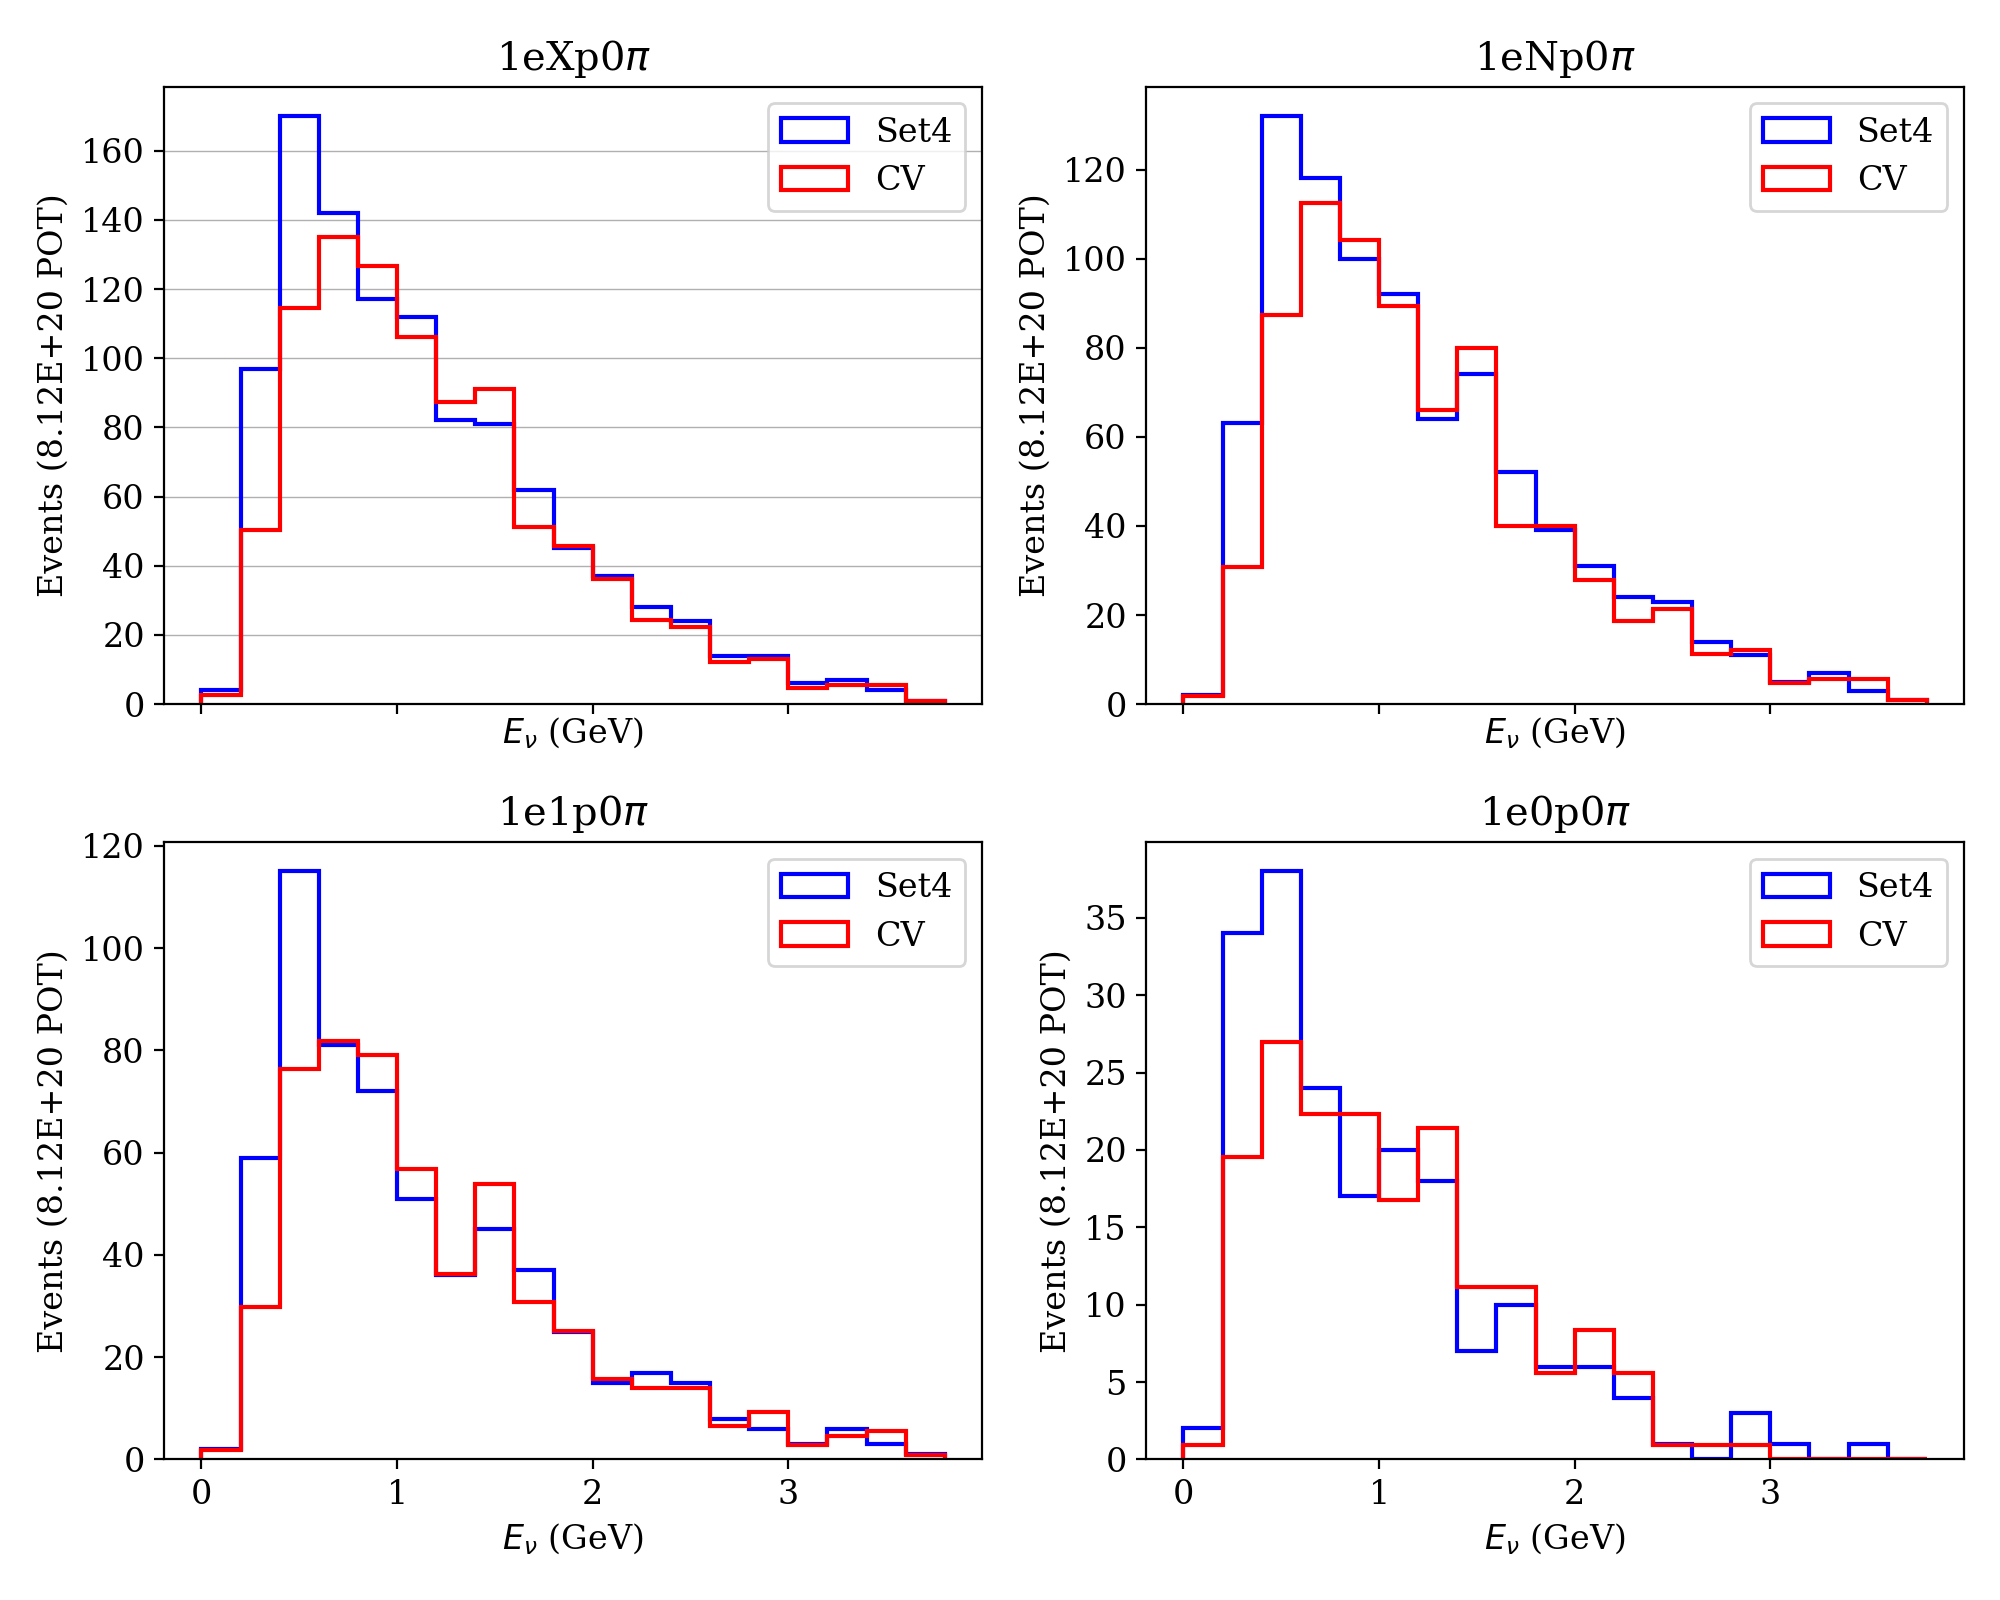

In [63]:
bins = np.arange(0,4.0,0.2)
var="e"
q=query_nue_cc
title="CV, $\\nu_\e$ CC Breakdown"
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv_e = ev_df_cv.query(q)
df_cv_1e0p = ev_df_cv.query(query_1e0p)
df_cv_1e1p = ev_df_cv.query(query_1e1p)
df_cv_1eNp = ev_df_cv.query(query_1eNp)
df_cv_1eXp = ev_df_cv.query(query_1eXp)

df_fd_e = ev_df_fd.query(q)
df_fd_1e0p = ev_df_fd.query(query_1e0p)
df_fd_1e1p = ev_df_fd.query(query_1e1p)
df_fd_1eNp = ev_df_fd.query(query_1eNp)
df_fd_1eXp = ev_df_fd.query(query_1eXp)

fig,ax = plt.subplots(2,2,sharex=True)

ax[0][0].grid(axis='y', linewidth=0.5)
ax[0][0].hist(df_fd_1eXp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][0].hist(df_cv_1eXp[var], weights=df_cv_1eXp["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][0].set_title("1eXp0$\pi$")
ax[0][0].legend()
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)

ax[0][1].hist(df_fd_1eNp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][1].hist(df_cv_1eNp[var], weights=df_cv_1eNp["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][1].set_title("1eNp0$\pi$")
ax[0][1].legend()
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)

ax[1][0].hist(df_fd_1e1p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][0].hist(df_cv_1e1p[var], weights=df_cv_1e1p["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][0].set_title("1e1p0$\pi$")
ax[1][0].legend()
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)

ax[1][1].hist(df_fd_1e0p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][1].hist(df_cv_1e0p[var], weights=df_cv_1e0p["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][1].set_title("1e0p0$\pi$")
ax[1][1].legend()
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)

plt.tight_layout()
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_e_breakdowncomp_%s.png"%fd_leg)

<IPython.core.display.Javascript object>


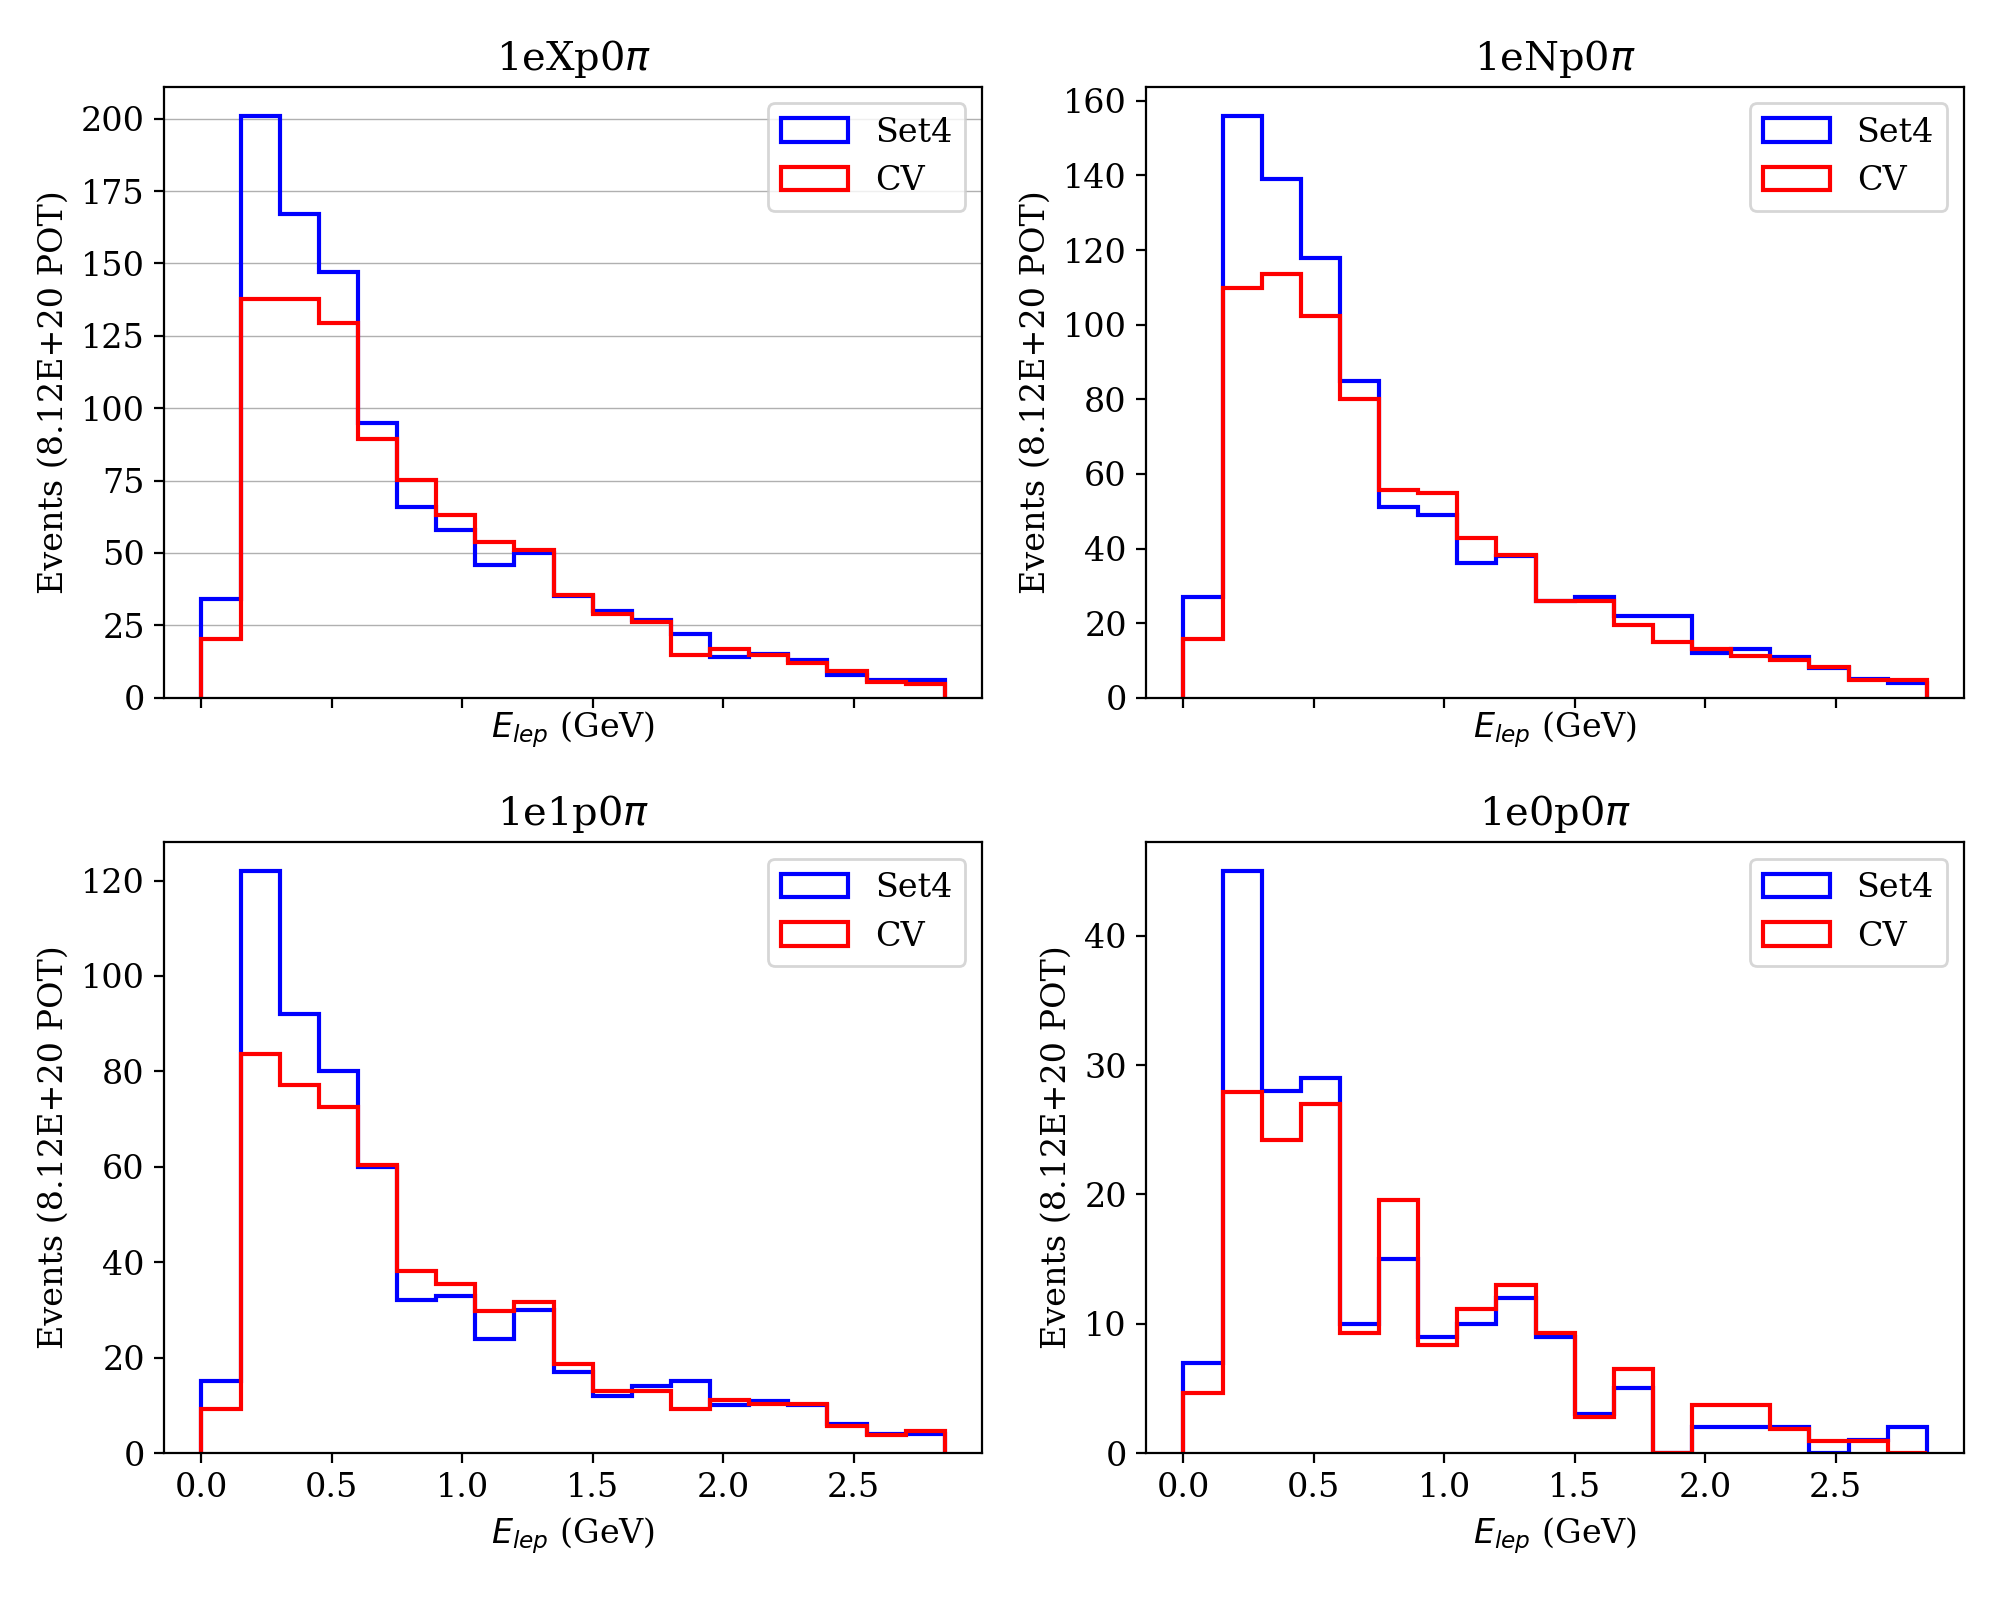

In [64]:
bins = np.arange(0,3.0,0.15)
var="e_lep"
q=query_nue_cc
title="CV, $\\nu_\e$ CC Breakdown"
xlabel="$E_{lep}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv_e = ev_df_cv.query(q)
df_cv_1e0p = ev_df_cv.query(query_1e0p)
df_cv_1e1p = ev_df_cv.query(query_1e1p)
df_cv_1eNp = ev_df_cv.query(query_1eNp)
df_cv_1eXp = ev_df_cv.query(query_1eXp)

df_fd_e = ev_df_fd.query(q)
df_fd_1e0p = ev_df_fd.query(query_1e0p)
df_fd_1e1p = ev_df_fd.query(query_1e1p)
df_fd_1eNp = ev_df_fd.query(query_1eNp)
df_fd_1eXp = ev_df_fd.query(query_1eXp)

fig,ax = plt.subplots(2,2,sharex=True)

ax[0][0].grid(axis='y', linewidth=0.5)
ax[0][0].hist(df_fd_1eXp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][0].hist(df_cv_1eXp[var], weights=df_cv_1eXp["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][0].set_title("1eXp0$\pi$")
ax[0][0].legend()
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)

ax[0][1].hist(df_fd_1eNp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][1].hist(df_cv_1eNp[var], weights=df_cv_1eNp["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][1].set_title("1eNp0$\pi$")
ax[0][1].legend()
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)

ax[1][0].hist(df_fd_1e1p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][0].hist(df_cv_1e1p[var], weights=df_cv_1e1p["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][0].set_title("1e1p0$\pi$")
ax[1][0].legend()
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)

ax[1][1].hist(df_fd_1e0p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][1].hist(df_cv_1e0p[var], weights=df_cv_1e0p["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][1].set_title("1e0p0$\pi$")
ax[1][1].legend()
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)

plt.tight_layout()
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_elep_breakdowncomp_%s.png"%fd_leg)

<IPython.core.display.Javascript object>


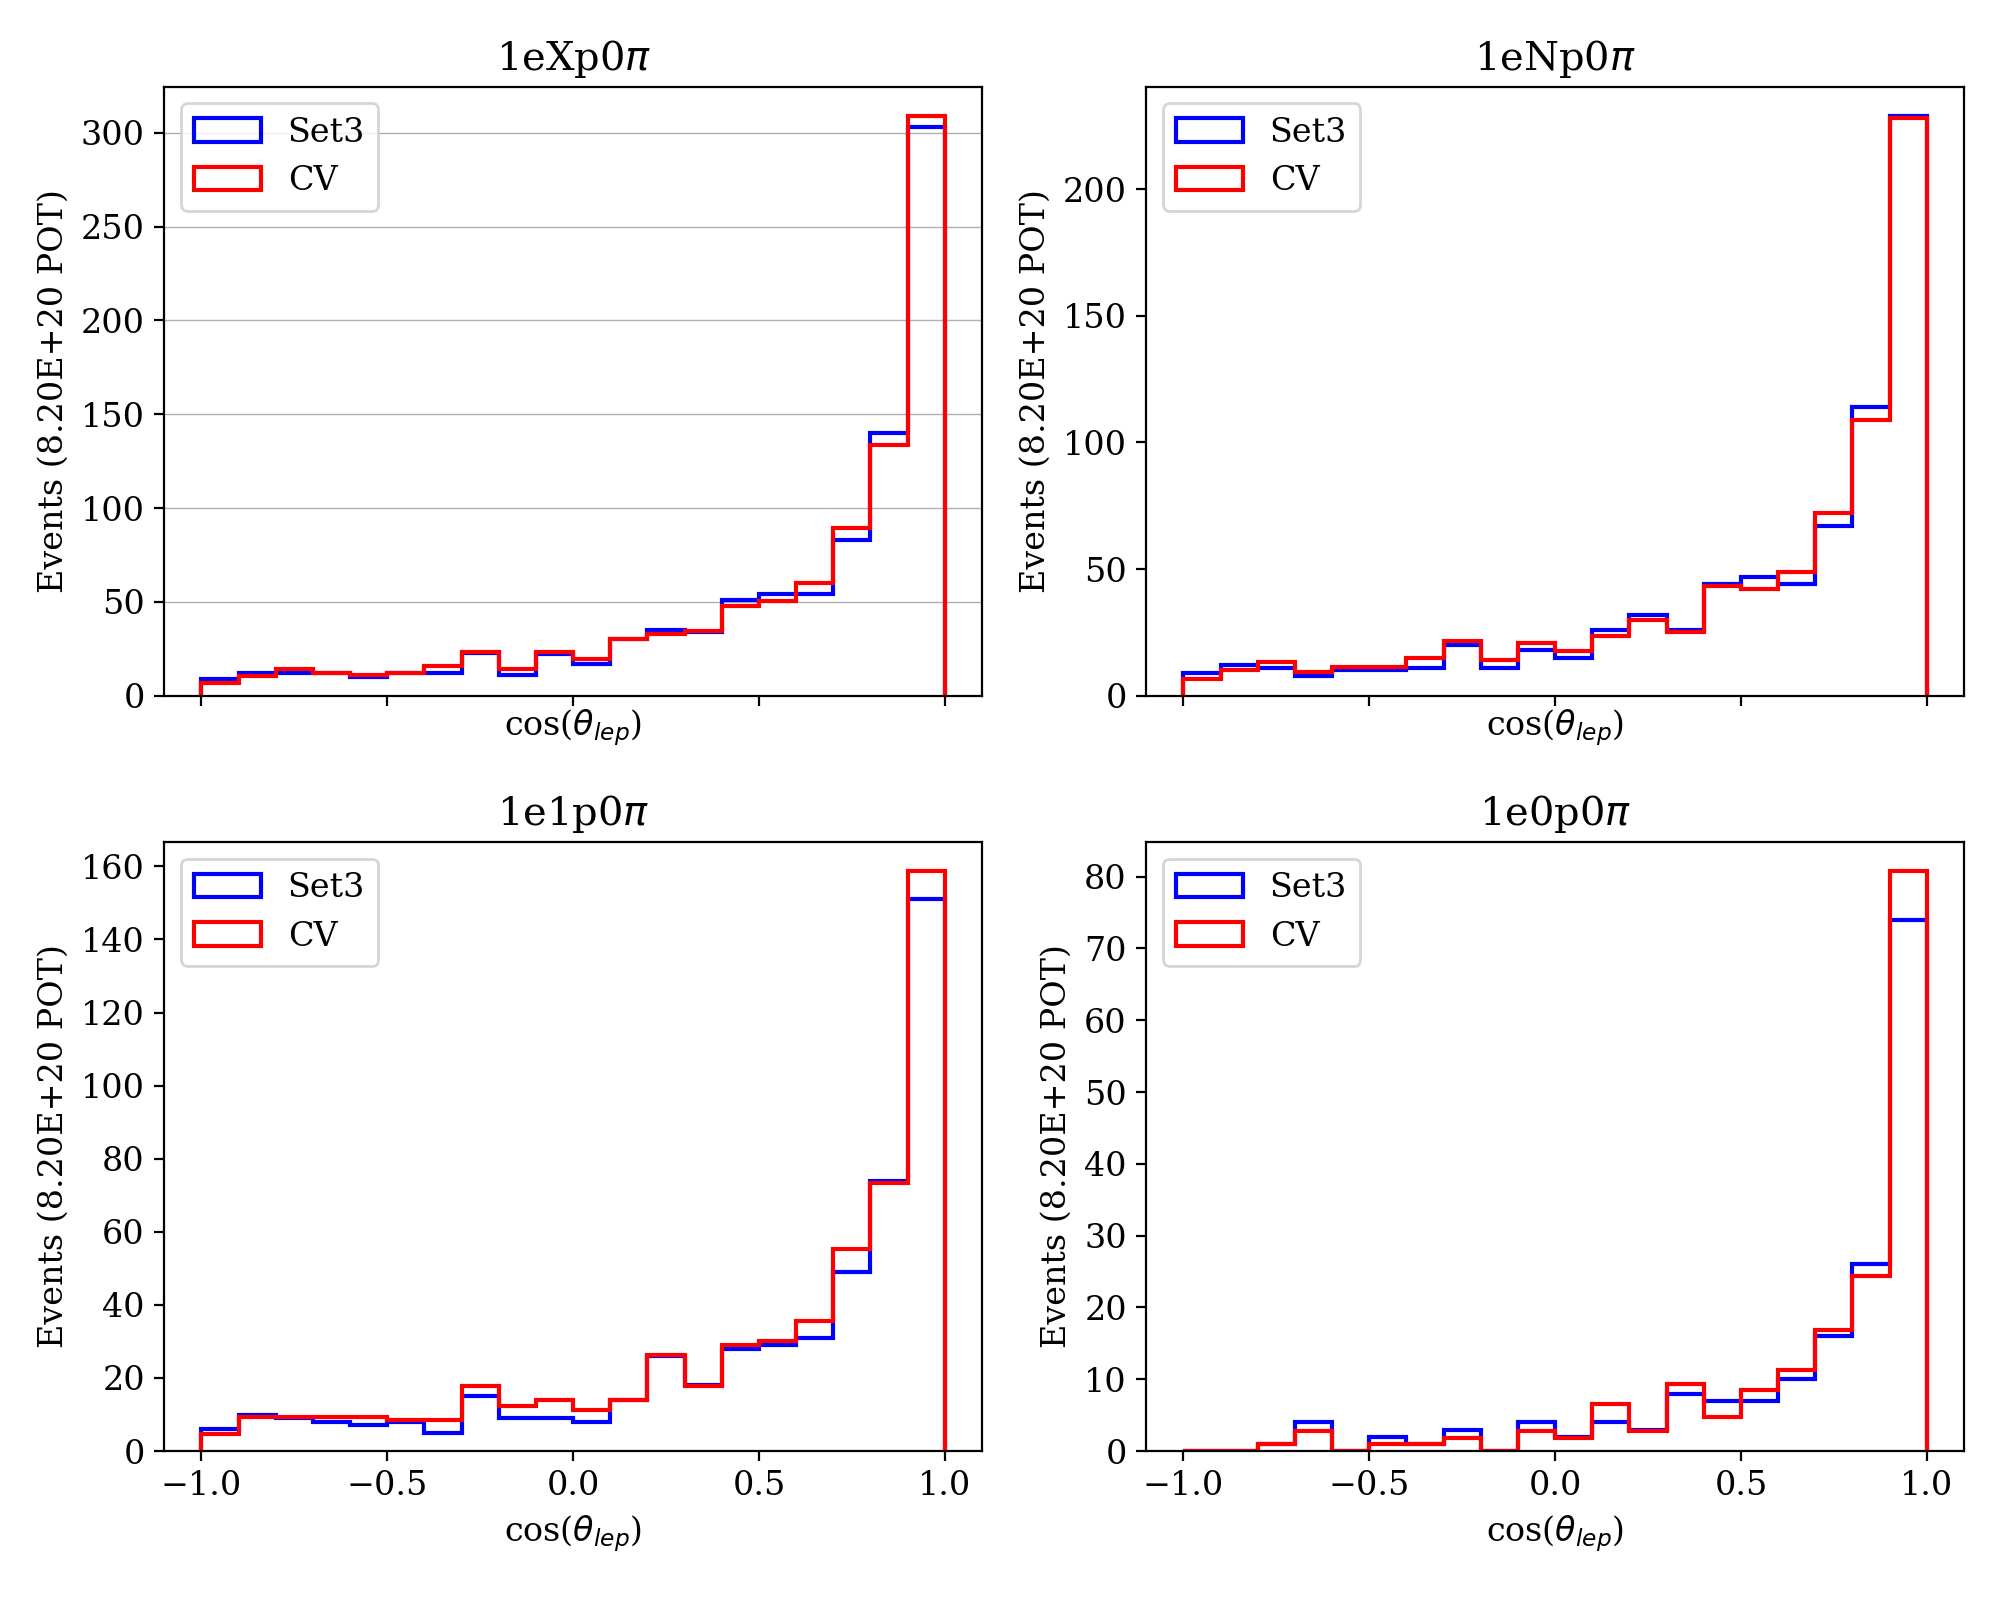

In [74]:
bins = np.arange(-1.0,1.1,0.1)
var="costheta_lep"
q=query_nue_cc
title="CV, $\\nu_\e$ CC Breakdown"
xlabel="cos($\\theta_{lep}$)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv_e = ev_df_cv.query(q)
df_cv_1e0p = ev_df_cv.query(query_1e0p)
df_cv_1e1p = ev_df_cv.query(query_1e1p)
df_cv_1eNp = ev_df_cv.query(query_1eNp)
df_cv_1eXp = ev_df_cv.query(query_1eXp)

df_fd_e = ev_df_fd.query(q)
df_fd_1e0p = ev_df_fd.query(query_1e0p)
df_fd_1e1p = ev_df_fd.query(query_1e1p)
df_fd_1eNp = ev_df_fd.query(query_1eNp)
df_fd_1eXp = ev_df_fd.query(query_1eXp)

fig,ax = plt.subplots(2,2,sharex=True)

ax[0][0].grid(axis='y', linewidth=0.5)
ax[0][0].hist(df_fd_1eXp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][0].hist(df_cv_1eXp[var], weights=df_cv_1eXp["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][0].set_title("1eXp0$\pi$")
ax[0][0].legend(loc=2)
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)

ax[0][1].hist(df_fd_1eNp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][1].hist(df_cv_1eNp[var], weights=df_cv_1eNp["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][1].set_title("1eNp0$\pi$")
ax[0][1].legend(loc=2)
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)

ax[1][0].hist(df_fd_1e1p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][0].hist(df_cv_1e1p[var], weights=df_cv_1e1p["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][0].set_title("1e1p0$\pi$")
ax[1][0].legend(loc=2)
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)

ax[1][1].hist(df_fd_1e0p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][1].hist(df_cv_1e0p[var], weights=df_cv_1e0p["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][1].set_title("1e0p0$\pi$")
ax[1][1].legend(loc=2)
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)

plt.tight_layout()
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_costhetalep_breakdowncomp_%s.png"%fd_leg)

<IPython.core.display.Javascript object>


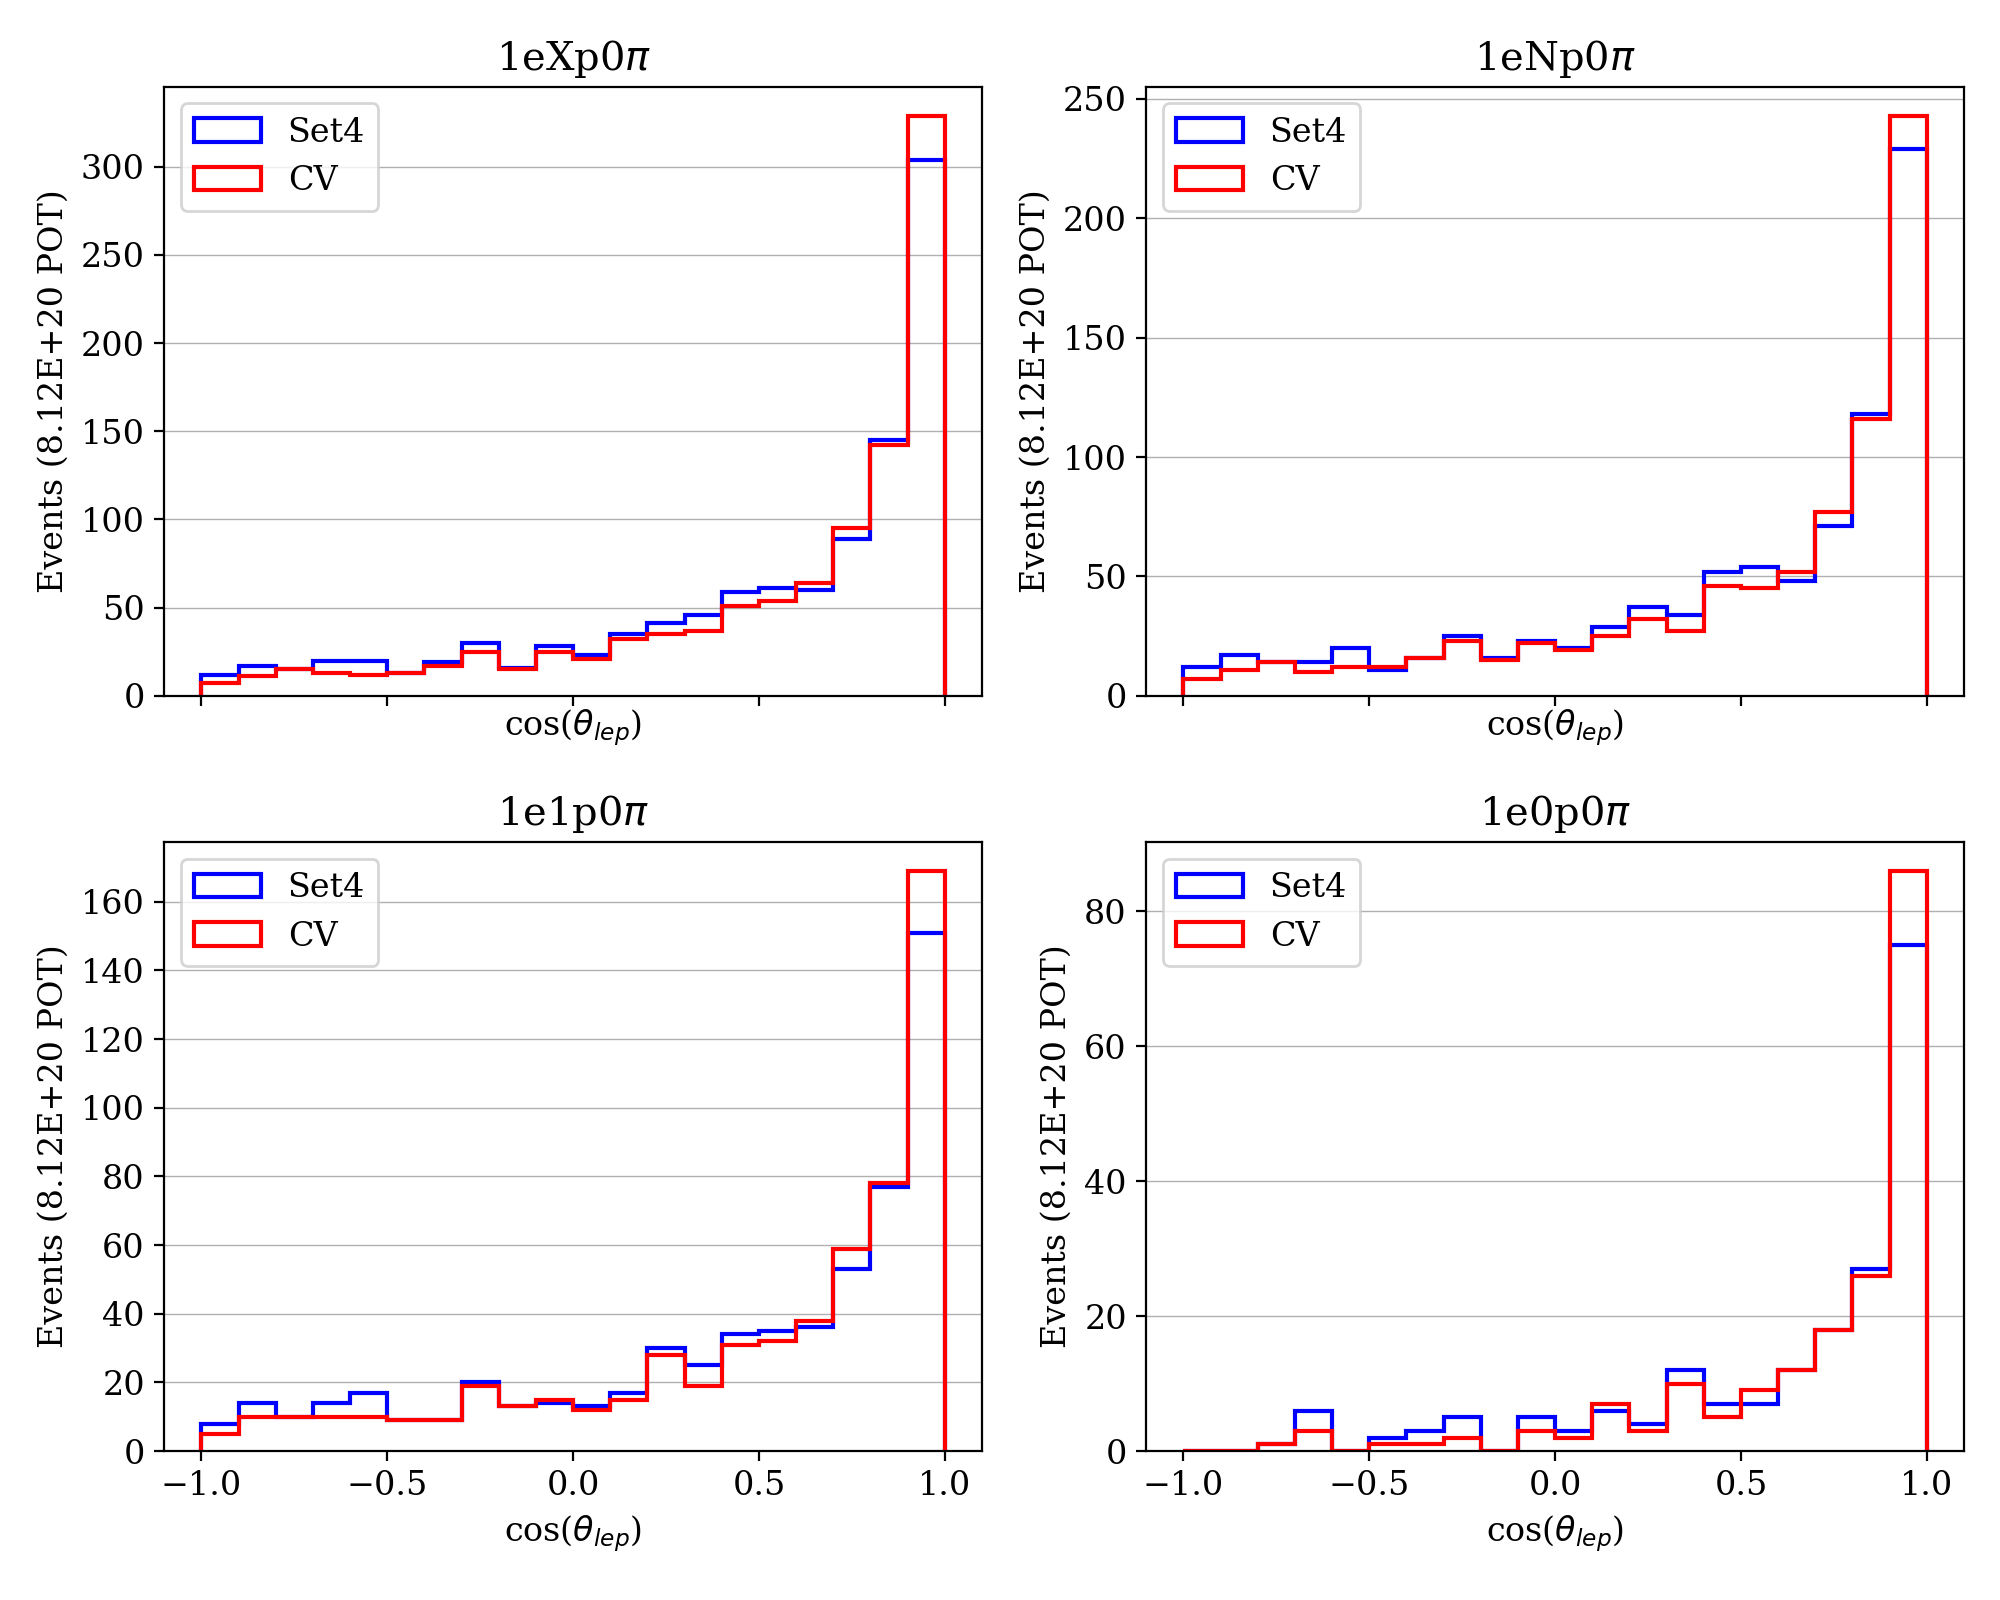

In [66]:
bins = np.arange(-1.0,1.1,0.1)
var="costheta_lep"
q=query_nue_cc
title="CV, $\\nu_\e$ CC Breakdown"
xlabel="cos($\\theta_{lep}$)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv_e = ev_df_cv.query(q)
df_cv_1e0p = ev_df_cv.query(query_1e0p)
df_cv_1e1p = ev_df_cv.query(query_1e1p)
df_cv_1eNp = ev_df_cv.query(query_1eNp)
df_cv_1eXp = ev_df_cv.query(query_1eXp)

df_fd_e = ev_df_fd.query(q)
df_fd_1e0p = ev_df_fd.query(query_1e0p)
df_fd_1e1p = ev_df_fd.query(query_1e1p)
df_fd_1eNp = ev_df_fd.query(query_1eNp)
df_fd_1eXp = ev_df_fd.query(query_1eXp)

fig,ax = plt.subplots(2,2,sharex=True)

ax[0][0].grid(axis='y', linewidth=0.5)
ax[0][0].hist(df_fd_1eXp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][0].hist(df_cv_1eXp[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][0].set_title("1eXp0$\pi$")
ax[0][0].legend(loc=2)
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)

ax[0][1].grid(axis='y', linewidth=0.5)
ax[0][1].hist(df_fd_1eNp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][1].hist(df_cv_1eNp[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][1].set_title("1eNp0$\pi$")
ax[0][1].legend(loc=2)
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)

ax[1][0].grid(axis='y', linewidth=0.5)
ax[1][0].hist(df_fd_1e1p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][0].hist(df_cv_1e1p[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][0].set_title("1e1p0$\pi$")
ax[1][0].legend(loc=2)
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)

ax[1][1].grid(axis='y', linewidth=0.5)
ax[1][1].hist(df_fd_1e0p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][1].hist(df_cv_1e0p[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][1].set_title("1e0p0$\pi$")
ax[1][1].legend(loc=2)
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)

plt.tight_layout()
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_costhetalep_breakdowncomp_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,4.0,0.2)
var="e"
q=query_nue_cc
title="CV, $\\nu_\mu$ CC Breakdown"
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv_e = ev_df_cv.query(q)
df_cv_1e0p = ev_df_cv.query(query_1mu0p)
df_cv_1e1p = ev_df_cv.query(query_1mu1p)
df_cv_1eNp = ev_df_cv.query(query_1muNp)
df_cv_1eXp = ev_df_cv.query(query_1muXp)

df_fd_e = ev_df_fd.query(q)
df_fd_1e0p = ev_df_fd.query(query_1mu0p)
df_fd_1e1p = ev_df_fd.query(query_1mu1p)
df_fd_1eNp = ev_df_fd.query(query_1muNp)
df_fd_1eXp = ev_df_fd.query(query_1muXp)

fig,ax = plt.subplots(2,2,sharex=True)

ax[0][0].grid(axis='y', linewidth=0.5)
ax[0][0].hist(df_fd_1eXp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][0].hist(df_cv_1eXp[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][0].set_title("1$\mu$Xp0$\pi$")
ax[0][0].legend()
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)

ax[0][1].hist(df_fd_1eNp[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[0][1].hist(df_cv_1eNp[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[0][1].set_title("1$\mu$Np0$\pi$")
ax[0][1].legend()
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)

ax[1][0].hist(df_fd_1e1p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][0].hist(df_cv_1e1p[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][0].set_title("1$\mu$1p0$\pi$")
ax[1][0].legend()
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)

ax[1][1].hist(df_fd_1e0p[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
ax[1][1].hist(df_cv_1e0p[var], color='red', label=cv_leg, bins=bins,**pltops_hist)
ax[1][1].set_title("1$\mu$0p0$\pi$")
ax[1][1].legend()
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)

plt.tight_layout()
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_breakdowncomp_%s.png"%fd_leg)

In [ ]:
bins = np.arange(-1.0,1.0,0.1)
var="costheta_lep"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="cos($\\theta_{\mu}$)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_costheta_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,2.0,0.05)
var="e_lep"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="$E_{\mu}$"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_emu_%s.png"%fd_leg)

In [ ]:
bins = np.arange(-1.0,1.1,0.1)
var="costheta_lep"
q=query_nue_cc
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="cos($\\theta_{e}$)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_costheta_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e_lep"
q=query_nue_cc
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="$E_{e}$"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_ee_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e_lep"
q="(n_chpi>0 or n_pi0>0) and n_e==1 and n_gamma==0"
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="$E_{e}$"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/nuecc_ee_1eXpNpi%s.png"%fd_leg)

In [ ]:
bins = np.arange(0,3.0,0.1)
var="e_lep"
q="(n_chpi==0 and n_pi0==0) and n_p_40MeV>-1 and n_e==1 and n_gamma==0"
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="$E_{e}$"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("/Users/wketchum/Downloads/nuecc_ee_1eXpNpi%s.png"%fd_leg)

In [ ]:
bins = np.arange(0.0,1.5,0.05)
var="p_pi0"
q=query_ccpi0
title="%s, $\\nu_\mu$ CC $\pi^0$"%(fd_title)
xlabel="$\pi^0$ momentum (GeV/c)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ccpi0_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0.0,1.5,0.05)
var="p_pi0"
q=query_ncpi0
title="%s, $\\nu_\mu$ NC $\pi^0$"%(fd_title)
xlabel="$\pi^0$ momentum (GeV/c)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ncpi0_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0.0,1.,0.1)
var="e_gamma"
q=query_1gXp
title="%s, Single Photon"%(fd_title)
xlabel="$\gamma$ Energy (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/singlephoton_e_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0.0,1.,0.1)
var="e_gamma"
q=query_1gXp
title="%s, Single Photon"%(fd_title)
xlabel="$\gamma$ Energy (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_1gXp = ev_df_fd.query(q)
df_1gNp = ev_df_fd.query(query_1gNp)
df_1g0p = ev_df_fd.query(query_1g0p)
df_1g1p = ev_df_fd.query(query_1g1p)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
#plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_1gXp[var], color='blue', label="1gXp0pi", bins=bins,**pltops_hist)
plt.hist(df_1gNp[var], color='green', label="1gNp0pi", bins=bins,**pltops_hist)
plt.hist(df_1g1p[var], color='purple', label="1g1p0pi", bins=bins,**pltops_hist)
plt.hist(df_1g0p[var], color='orange', label="1g0p0pi", bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/singlephoton_e_breakdown_%s.png"%fd_leg)

In [ ]:
ev_df_fd.query(query_1gNp)["ke_p1"]

In [ ]:
np.min(ev_df_cv.query(query_1eNp)["ke_p1"])

In [ ]:
bins = np.arange(0.0,1.,0.1)
var="e"
q=query_1e0p
title="%s, Single Photon"%(fd_title)
xlabel="$\gamma$ Energy (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_1gXp = ev_df_fd.query(q)
df_1gNp = ev_df_fd.query(query_1gNp)
df_1g0p = ev_df_fd.query(query_1g0p)
df_1g1p = ev_df_fd.query(query_1g1p)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
#plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_1gXp[var], color='blue', label="1gXp0pi", bins=bins,**pltops_hist)
plt.hist(df_1gNp[var], color='green', label="1gNp0pi", bins=bins,**pltops_hist)
plt.hist(df_1g1p[var], color='purple', label="1g1p0pi", bins=bins,**pltops_hist)
plt.hist(df_1g0p[var], color='orange', label="1g0p0pi", bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/singlephoton_e_breakdown_%s.png"%fd_leg)